# CSI Obfuscation

## Imports

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '4'

from dichasus_cf0x import training_set, test_set
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

## Load Datasets -> From TensorFlow to NumPy

### Training Set

In [2]:
groundtruth_positions = []
csi_freq_domain_RAW = []
timestamps = []

for cfo, csi, pos, snr, time in training_set.batch(1000):
    csi_freq_domain_RAW.append(csi.numpy())
    groundtruth_positions.append(pos.numpy())
    timestamps.append(time.numpy())

csi_freq_domain_RAW = np.concatenate(csi_freq_domain_RAW)
groundtruth_positions = np.concatenate(groundtruth_positions)
timestamps = np.concatenate(timestamps)

In [3]:
csi_freq_domain_RAW = csi_freq_domain_RAW[np.argsort(timestamps)]
groundtruth_positions = groundtruth_positions[np.argsort(timestamps)]
timestamps = timestamps[np.argsort(timestamps)]

### Test Set

In [4]:
groundtruth_positions_test = []
csi_freq_domain_RAW_test = []
timestamps_test = []

for cfo, csi, pos, snr, time in test_set.batch(1000):
    csi_freq_domain_RAW_test.append(csi.numpy())
    groundtruth_positions_test.append(pos.numpy())
    timestamps_test.append(time.numpy())

csi_freq_domain_RAW_test = np.concatenate(csi_freq_domain_RAW_test)
groundtruth_positions_test = np.concatenate(groundtruth_positions_test)
timestamps_test = np.concatenate(timestamps_test)

In [5]:
csi_freq_domain_RAW_test = csi_freq_domain_RAW_test[np.argsort(timestamps_test)]
groundtruth_positions_test = groundtruth_positions_test[np.argsort(timestamps_test)]
timestamps_test = timestamps_test[np.argsort(timestamps_test)]

In [6]:
np.save("dataset/groundtruth_positions", groundtruth_positions)
np.save("dataset/groundtruth_positions_test", groundtruth_positions_test)

np.save("dataset/timestamps", timestamps)
np.save("dataset/timestamps_test", timestamps_test)

## Select Antenna Configuration

In [7]:
def select_arrays(csi, array_indices = [0,1,2,3], n_r = 2, n_c = 4):
    if not isinstance(array_indices, list):
        raise TypeError("array_indices must be a list.")
    return csi[:,array_indices,:n_r,:n_c]

In [8]:
array_list = [0,1,2,3]
num_rows = 2
num_cols = 4

csi_freq_domain_RAW = select_arrays(csi_freq_domain_RAW, array_list, num_rows, num_cols)
csi_freq_domain_RAW_test = select_arrays(csi_freq_domain_RAW_test, array_list, num_rows, num_cols)

print(csi_freq_domain_RAW.shape)
print(csi_freq_domain_RAW_test.shape)

(20851, 4, 2, 4, 64)
(20851, 4, 2, 4, 64)


## Visualizing the Dataset

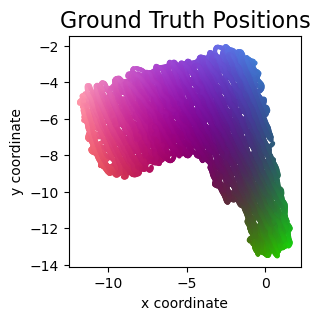

In [9]:
def plot_colorized(positions, groundtruth_positions, title = None, show = True, alpha = 1.0):
    # Generate RGB colors for datapoints
    center_point = np.zeros(2, dtype = np.float32)
    center_point[0] = 0.5 * (np.min(groundtruth_positions[:, 0], axis = 0) + np.max(groundtruth_positions[:, 0], axis = 0))
    center_point[1] = 0.5 * (np.min(groundtruth_positions[:, 1], axis = 0) + np.max(groundtruth_positions[:, 1], axis = 0))
    NormalizeData = lambda in_data : (in_data - np.min(in_data)) / (np.max(in_data) - np.min(in_data))
    rgb_values = np.zeros((groundtruth_positions.shape[0], 3))
    rgb_values[:, 0] = 1 - 0.9 * NormalizeData(groundtruth_positions[:, 0])
    rgb_values[:, 1] = 0.8 * NormalizeData(np.square(np.linalg.norm(groundtruth_positions[:,:2] - center_point, axis=1)))
    rgb_values[:, 2] = 0.9 * NormalizeData(groundtruth_positions[:, 1])

    # Plot datapoints
    plt.figure(figsize=(3, 3))
    if title is not None:
        plt.title(title, fontsize=16)
    plt.scatter(positions[:, 0], positions[:, 1], c = rgb_values, alpha = alpha, s = 10, linewidths = 0)
    plt.xlabel("x coordinate")
    plt.ylabel("y coordinate")
    if show:
        plt.show()

plot_colorized(groundtruth_positions[:,:2], groundtruth_positions[:,:2], title="Ground Truth Positions")

## Create Obfuscation Signal

In [10]:
def create_obfuscation_signal(csi, L_p = 0):
    # sequence of random amplitudes and phases of length L_p
    amplitudes = np.random.uniform(0, 1, (csi.shape[0], L_p))
    phases = np.random.uniform(0, 2*np.pi, (csi.shape[0], L_p))
    # normalized, zero-padded version of the sequence of length 64 (number of subcarriers in dataset)
    p = np.zeros((csi.shape[0], csi.shape[-1]), dtype = np.csingle)
    p[:,:L_p] = amplitudes * np.exp(1j * phases)
    p = p / np.linalg.norm(p, axis = -1, keepdims = True)
    # return frequency-domain obfuscation signal
    return np.fft.fft(p, axis = -1)

v_ob = create_obfuscation_signal(csi_freq_domain_RAW, 16)
v_ob_test = create_obfuscation_signal(csi_freq_domain_RAW_test, 16)

### Visualize Obfuscation Signal in Frequency Domain

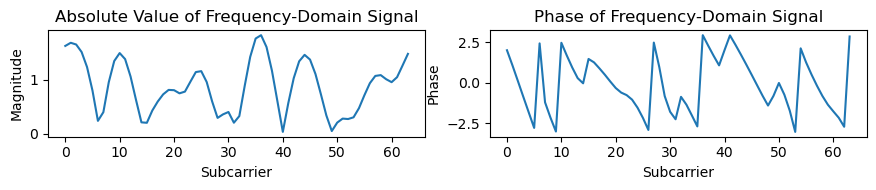

<Figure size 640x480 with 0 Axes>

In [11]:
sample_index = 0
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 2))
# Plot the absolute value of the time-domain signal in the first subplot
ax1.plot(np.abs(v_ob[sample_index]))
ax1.set_title("Absolute Value of Frequency-Domain Signal")
ax1.set_xlabel("Subcarrier")
ax1.set_ylabel("Magnitude")
#Plot the absolute value of the frequency domain signal in the second subplot.
ax2.plot(np.angle(v_ob[sample_index]))
ax2.set_title("Phase of Frequency-Domain Signal")
ax2.set_xlabel("Subcarrier")
ax2.set_ylabel("Phase")
# Adjust spacing between subplots
plt.tight_layout()
# Show the figure
plt.show()
plt.clf()

## Obfuscate CSI

In [12]:
# Multiply frequency-domain obfuscation signal with the CSI
def obfuscate_csi(csi, v):
    return csi * np.expand_dims(v, axis=(1,2,3))

csi_freq_domain_OBFUSCATED = obfuscate_csi(csi_freq_domain_RAW, v_ob)
csi_freq_domain_OBFUSCATED_test = obfuscate_csi(csi_freq_domain_RAW_test, v_ob_test)

## Recover CSI Features

In [13]:
# CSI recovery method
def recover_csi(csi_ob):
    antenna_count = np.prod(csi_ob.shape[1:4])
    v_ob_pred = np.zeros((csi_ob.shape[0], csi_ob.shape[-1]), dtype= np.csingle)
    
    for d in range(v_ob_pred.shape[0]):
        # autocorrelation matrix over the subcarrier dimension, averaged over all receiver antennas
        R = np.einsum('bijs, bijt -> st', csi_ob[d], np.conj(csi_ob[d])) / antenna_count
        # eigendecomposition of R
        w, v = np.linalg.eigh(R)
        principal = np.argmax(w)
        # estimate obfuscation signal
        v_ob_pred[d] = np.sqrt(w[principal])*(v[:, principal]/np.linalg.norm(v[:, principal]))
    # recover CSI features based on observed CSI and estimated obfuscation signal
    return csi_ob / np.expand_dims(v_ob_pred, axis=(1,2,3))

### Recover RAW CSI

In [14]:
csi_freq_domain_RAW_RECOVERED = recover_csi(csi_freq_domain_RAW)
csi_freq_domain_RAW_RECOVERED_test = recover_csi(csi_freq_domain_RAW_test)

### Recover Obfuscated CSI

In [15]:
csi_freq_domain_RECOVERED = recover_csi(csi_freq_domain_OBFUSCATED)
csi_freq_domain_RECOVERED_test = recover_csi(csi_freq_domain_OBFUSCATED_test)

## Visualize CSI

### Frequency Domain

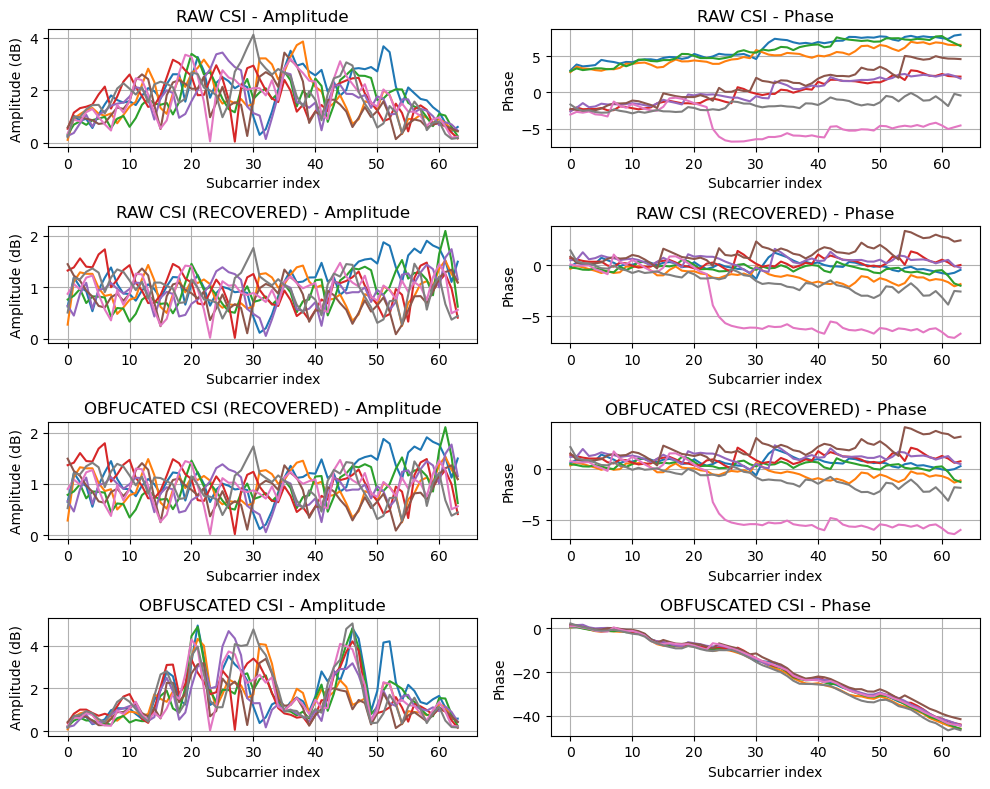

<Figure size 640x480 with 0 Axes>

In [16]:
sample_index = 100
fig = plt.figure(figsize=(10, 8))

plt.subplot(4, 2, 1)
plt.title('RAW CSI - Amplitude')
plt.xlabel('Subcarrier index')
plt.ylabel('Amplitude (dB)')
plt.grid(True)

plt.subplot(4, 2, 2)
plt.title('RAW CSI - Phase')
plt.xlabel('Subcarrier index')
plt.ylabel('Phase')
plt.grid(True)

plt.subplot(4, 2, 3)
plt.title('RAW CSI (RECOVERED) - Amplitude')
plt.xlabel('Subcarrier index')
plt.ylabel('Amplitude (dB)')
plt.grid(True)

plt.subplot(4, 2, 4)
plt.title('RAW CSI (RECOVERED) - Phase')
plt.xlabel('Subcarrier index')
plt.ylabel('Phase')
plt.grid(True)

plt.subplot(4, 2, 5)
plt.title('OBFUCATED CSI (RECOVERED) - Amplitude')
plt.xlabel('Subcarrier index')
plt.ylabel('Amplitude (dB)')
plt.grid(True)

plt.subplot(4, 2, 6)
plt.title('OBFUCATED CSI (RECOVERED) - Phase')
plt.xlabel('Subcarrier index')
plt.ylabel('Phase')
plt.grid(True)

plt.subplot(4, 2, 7)
plt.title('OBFUSCATED CSI - Amplitude')
plt.xlabel('Subcarrier index')
plt.ylabel('Amplitude (dB)')
plt.grid(True)

plt.subplot(4, 2, 8)
plt.title('OBFUSCATED CSI - Phase')
plt.xlabel('Subcarrier index')
plt.ylabel('Phase')
plt.grid(True)

for array_index in range(1):
    for row_index in range(csi_freq_domain_RAW.shape[2]):
        for antenna_index in range(csi_freq_domain_RAW.shape[3]):
    
            plt.subplot(4, 2, 1)
            plt.plot(np.abs(csi_freq_domain_RAW[sample_index, array_index, row_index, antenna_index, :]), label=f'Arr {array_index} Ant {antenna_index}')
    
            plt.subplot(4, 2, 2)
            plt.plot(np.unwrap(np.angle(csi_freq_domain_RAW[sample_index, array_index, row_index, antenna_index, :] )), label=f'Arr {array_index} Ant {antenna_index}')

            plt.subplot(4, 2, 3)
            plt.plot(np.abs(csi_freq_domain_RAW_RECOVERED[sample_index, array_index, row_index, antenna_index, :]), label=f'Arr {array_index} Ant {antenna_index}')
    
            plt.subplot(4, 2, 4)
            plt.plot(np.unwrap(np.angle(csi_freq_domain_RAW_RECOVERED[sample_index, array_index, row_index, antenna_index, :] )), label=f'Arr {array_index} Ant {antenna_index}')
    
            plt.subplot(4, 2, 5)
            plt.plot(np.abs(csi_freq_domain_RECOVERED[sample_index, array_index, row_index, antenna_index, :]), label=f'Arr {array_index} Ant {antenna_index}')
    
            plt.subplot(4, 2, 6)
            plt.plot(np.unwrap(np.angle(csi_freq_domain_RECOVERED[sample_index, array_index, row_index, antenna_index, :] )), label=f'Arr {array_index} Ant {antenna_index}')
    
            plt.subplot(4, 2, 7)
            plt.plot(np.abs(csi_freq_domain_OBFUSCATED[sample_index, array_index, row_index, antenna_index, :]), label=f'Arr {array_index} Ant {antenna_index}')
    
            plt.subplot(4, 2, 8)
            plt.plot(np.unwrap(np.angle(csi_freq_domain_OBFUSCATED[sample_index, array_index, row_index, antenna_index, :] )), label=f'Arr {array_index} Ant {antenna_index}')
        
fig.tight_layout()

plt.show()
plt.clf()

### Time Domain

In [17]:
# Convert frequency-domain CSI to time-domain CSI

# Training set
csi_time_domain_RAW = np.fft.fftshift(np.fft.ifft(np.fft.fftshift(csi_freq_domain_RAW, axes=-1)),axes=-1)
csi_time_domain_RAW_RECOVERED = np.fft.fftshift(np.fft.ifft(np.fft.fftshift(csi_freq_domain_RAW_RECOVERED, axes=-1)),axes=-1)
csi_time_domain_OBFUSCATED = np.fft.fftshift(np.fft.ifft(np.fft.fftshift(csi_freq_domain_OBFUSCATED, axes=-1)),axes=-1)
csi_time_domain_RECOVERED = np.fft.fftshift(np.fft.ifft(np.fft.fftshift(csi_freq_domain_RECOVERED, axes=-1)),axes=-1)

# Test set
csi_time_domain_RAW_test = np.fft.fftshift(np.fft.ifft(np.fft.fftshift(csi_freq_domain_RAW_test, axes=-1)),axes=-1)
csi_time_domain_RAW_RECOVERED_test = np.fft.fftshift(np.fft.ifft(np.fft.fftshift(csi_freq_domain_RAW_RECOVERED_test, axes=-1)),axes=-1)
csi_time_domain_OBFUSCATED_test = np.fft.fftshift(np.fft.ifft(np.fft.fftshift(csi_freq_domain_OBFUSCATED_test, axes=-1)),axes=-1)
csi_time_domain_RECOVERED_test = np.fft.fftshift(np.fft.ifft(np.fft.fftshift(csi_freq_domain_RECOVERED_test, axes=-1)),axes=-1)

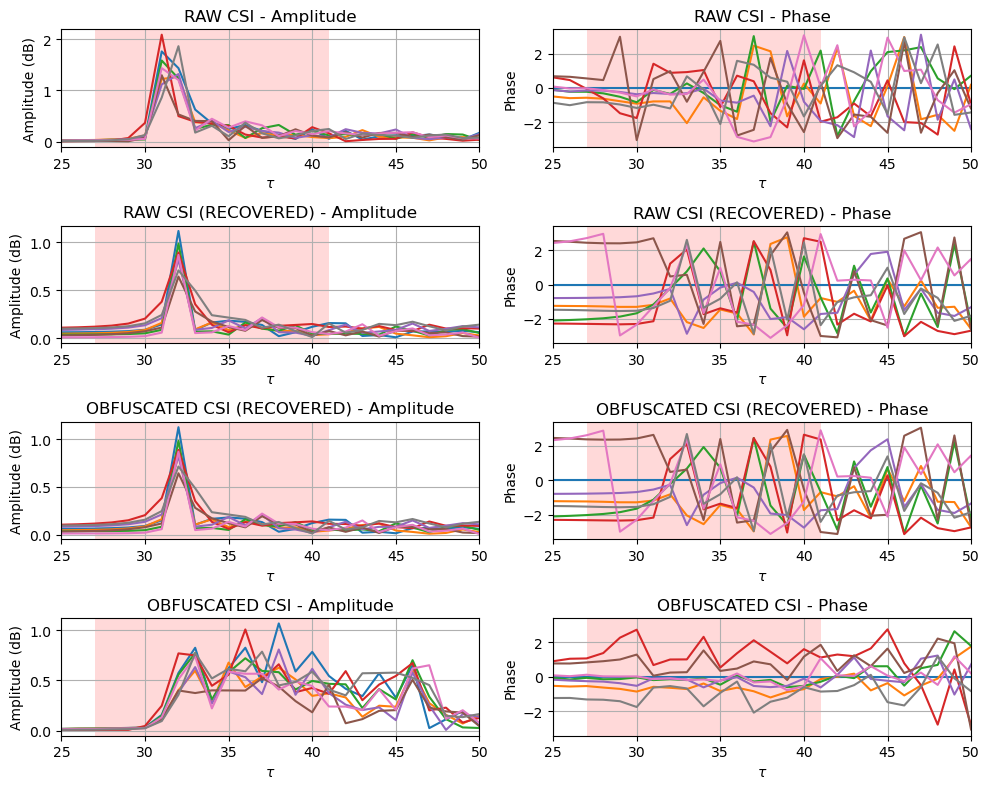

<Figure size 640x480 with 0 Axes>

In [18]:
sample_index = 10

lower_crop_tap = 25
upper_crop_tap = 50

start_tap = 27
stop_tap = 41

fig = plt.figure(figsize=(10, 8))

plt.subplot(4, 2, 1)
plt.title('RAW CSI - Amplitude')
plt.xlabel(r'$\tau$')
plt.axvspan(start_tap, stop_tap, facecolor='red', alpha=0.15)
plt.xlim(lower_crop_tap,upper_crop_tap)
plt.ylabel('Amplitude (dB)')
plt.grid(True)

plt.subplot(4, 2, 2)
plt.title('RAW CSI - Phase')
plt.xlabel(r'$\tau$')
plt.axvspan(start_tap, stop_tap, facecolor='red', alpha=0.15)
plt.xlim(lower_crop_tap,upper_crop_tap)
plt.ylabel('Phase')
plt.grid(True)

plt.subplot(4, 2, 3)
plt.title('RAW CSI (RECOVERED) - Amplitude')
plt.xlabel(r'$\tau$')
plt.axvspan(start_tap, stop_tap, facecolor='red', alpha=0.15)
plt.xlim(lower_crop_tap,upper_crop_tap)
plt.ylabel('Amplitude (dB)')
plt.grid(True)

plt.subplot(4, 2, 4)
plt.title('RAW CSI (RECOVERED) - Phase')
plt.xlabel(r'$\tau$')
plt.axvspan(start_tap, stop_tap, facecolor='red', alpha=0.15)
plt.xlim(lower_crop_tap,upper_crop_tap)
plt.ylabel('Phase')
plt.grid(True)

plt.subplot(4, 2, 5)
plt.title('OBFUSCATED CSI (RECOVERED) - Amplitude')
plt.xlabel(r'$\tau$')
plt.axvspan(start_tap, stop_tap, facecolor='red', alpha=0.15)
plt.xlim(lower_crop_tap,upper_crop_tap)
plt.ylabel('Amplitude (dB)')
plt.grid(True)

plt.subplot(4, 2, 6)
plt.title('OBFUSCATED CSI (RECOVERED) - Phase')
plt.xlabel(r'$\tau$')
plt.axvspan(start_tap, stop_tap, facecolor='red', alpha=0.15)
plt.xlim(lower_crop_tap,upper_crop_tap)
plt.ylabel('Phase')
plt.grid(True)

plt.subplot(4, 2, 7)
plt.title('OBFUSCATED CSI - Amplitude')
plt.xlabel(r'$\tau$')
plt.axvspan(start_tap, stop_tap, facecolor='red', alpha=0.15)
plt.xlim(lower_crop_tap,upper_crop_tap)
plt.ylabel('Amplitude (dB)')
plt.grid(True)

plt.subplot(4, 2, 8)
plt.title('OBFUSCATED CSI - Phase')
plt.xlabel(r'$\tau$')
plt.axvspan(start_tap, stop_tap, facecolor='red', alpha=0.15)
plt.xlim(lower_crop_tap,upper_crop_tap)
plt.ylabel('Phase')
plt.grid(True)

for array_index in range(1):
    for row_index in range(csi_time_domain_RAW.shape[2]):
        for antenna_index in range(csi_time_domain_RAW.shape[3]):
    
            plt.subplot(4, 2, 1)
            plt.plot(np.abs(csi_time_domain_RAW[sample_index, array_index, row_index, antenna_index, :]), label=f'Arr {array_index} Ant {antenna_index}')
    
            plt.subplot(4, 2, 2)
            plt.plot(np.angle(csi_time_domain_RAW[sample_index, array_index, row_index, antenna_index, :] * np.conj(csi_time_domain_RAW[sample_index, array_index, 0, 0, :]) ), label=f'Arr {array_index} Ant {antenna_index}')

            plt.subplot(4, 2, 3)
            plt.plot(np.abs(csi_time_domain_RAW_RECOVERED[sample_index, array_index, row_index, antenna_index, :]), label=f'Arr {array_index} Ant {antenna_index}')
    
            plt.subplot(4, 2, 4)
            plt.plot(np.angle(csi_time_domain_RAW_RECOVERED[sample_index, array_index, row_index, antenna_index, :] * np.conj(csi_time_domain_RAW_RECOVERED[sample_index, array_index, 0, 0, :]) ), label=f'Arr {array_index} Ant {antenna_index}')
    
            plt.subplot(4, 2, 5)
            plt.plot(np.abs(csi_time_domain_RECOVERED[sample_index, array_index, row_index, antenna_index, :]), label=f'Arr {array_index} Ant {antenna_index}')
    
            plt.subplot(4, 2, 6)
            plt.plot(np.angle(csi_time_domain_RECOVERED[sample_index, array_index, row_index, antenna_index, :] * np.conj(csi_time_domain_RECOVERED[sample_index, array_index, 0, 0, :]) ), label=f'Arr {array_index} Ant {antenna_index}')
    
            plt.subplot(4, 2, 7)
            plt.plot(np.abs(csi_time_domain_OBFUSCATED[sample_index, array_index, row_index, antenna_index, :]), label=f'Arr {array_index} Ant {antenna_index}')
    
            plt.subplot(4, 2, 8)
            plt.plot(np.angle(csi_time_domain_OBFUSCATED[sample_index, array_index, row_index, antenna_index, :] * np.conj(csi_time_domain_OBFUSCATED[sample_index, array_index, 0, 0, :]) ), label=f'Arr {array_index} Ant {antenna_index}')
        
fig.tight_layout()

plt.show()
plt.clf()

## Save as NumPy

### Frequency Domain

In [19]:
np.save("dataset/csi_freq_domain_RAW", csi_freq_domain_RAW)
np.save("dataset/csi_freq_domain_RAW_RECOVERED", csi_freq_domain_RAW_RECOVERED)
np.save("dataset/csi_freq_domain_OBFUSCATED", csi_freq_domain_OBFUSCATED)
np.save("dataset/csi_freq_domain_RECOVERED", csi_freq_domain_RECOVERED)

np.save("dataset/csi_freq_domain_RAW_test", csi_freq_domain_RAW_test)
np.save("dataset/csi_freq_domain_RAW_RECOVERED_test", csi_freq_domain_RAW_RECOVERED_test)
np.save("dataset/csi_freq_domain_OBFUSCATED_test", csi_freq_domain_OBFUSCATED_test)
np.save("dataset/csi_freq_domain_RECOVERED_test", csi_freq_domain_RECOVERED_test)

### Time Domain

In [20]:
np.save("dataset/csi_time_domain_RAW", csi_time_domain_RAW)
np.save("dataset/csi_time_domain_RAW_RECOVERED", csi_time_domain_RAW_RECOVERED)
np.save("dataset/csi_time_domain_OBFUSCATED", csi_time_domain_OBFUSCATED)
np.save("dataset/csi_time_domain_RECOVERED", csi_time_domain_RECOVERED)

np.save("dataset/csi_time_domain_RAW_test", csi_time_domain_RAW_test)
np.save("dataset/csi_time_domain_RAW_RECOVERED_test", csi_time_domain_RAW_RECOVERED_test)
np.save("dataset/csi_time_domain_OBFUSCATED_test", csi_time_domain_OBFUSCATED_test)
np.save("dataset/csi_time_domain_RECOVERED_test", csi_time_domain_RECOVERED_test)